# SLU12 - Feature Engineering

This SLU introduces you to basic feature engineering of numerical and categorical data. We'll look at scaling and binning for numerical data and encoding for categorical data. The choice of feature engineering mostly depends on the requirements of the model you're planning to use. Sometimes it also simplifies the data representation or creates a new feature from the features you already have (this last option is not covered here).

We will be using a preprocessed version of the `avengers` dataset, by [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/avengers).

<img src="https://ichef.bbci.co.uk/news/800/cpsprodpb/BF0D/production/_106090984_2e39b218-c369-452e-b5be-d2476f9d8728.jpg" width="400">)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5.6, 4.2]

In [2]:
avengers = pd.read_csv('data/avengers.csv', )
avengers.head()

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616,1269,1,0
1,Janet van Dyne,YES,FEMALE,Full,Earth-616,1165,1,1
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616,3068,1,1
3,Robert Bruce Banner,YES,MALE,Full,Earth-616,2089,1,1
4,Thor Odinson,YES,MALE,Full,Earth-616,2402,2,1


## 1. Types of data in Pandas <a class="anchor" id="types-data"></a>

The feature engineering you can choose from depends on the data type, so let's first review the pandas datatypes.

A dataset is a collection of values, usually either numbers or strings. When reading data from a file, pandas usually recognizes the numerical types and considers everything else an `object`.

In [3]:
avengers.dtypes

Name            object
Active          object
Gender          object
Membership      object
Universe        object
Appearances      int64
TotalDeaths      int64
TotalReturns     int64
dtype: object

We can use the `convert_dtypes` method to improve the type definition. It will convert the variables to the best possible dtypes using data types supporting the pandas null value `pd.NA`.

In [4]:
avengers = avengers.convert_dtypes()
avengers.dtypes

Name            string[python]
Active          string[python]
Gender          string[python]
Membership      string[python]
Universe        string[python]
Appearances              Int64
TotalDeaths              Int64
TotalReturns             Int64
dtype: object

Using these more specific data types is better because it allows you to use data type specific operations. For instance, there is a whole set of operations for strings, starting with the `str.` prefix. It also allows to select columns by data types in a more specific way.

The convenient `select_dtypes` method allows us to select variables (columns in our dataframe) by data type.

In [5]:
(avengers.select_dtypes(include='string')
         .head(3))

,Name,Active,Gender,Membership,Universe
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616
1,Janet van Dyne,YES,FEMALE,Full,Earth-616
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616


Pandas is based on NumPy and so recognizes the NumPy data types. It also has its own types, called extension types. We can roughly divide the pandas data types into
- basic numeric types such as integers and floats
- boolean types
- time related types such as datetime, timedelta, interval, period
- strings
- categorical type which can be represented by integers, strings or booleans

Here is a complete list of [pandas data types](https://pandas.pydata.org/docs/reference/arrays.html). Depending on the data type, we can divide features into numerical and categorical. So far, you have worked with numerical data with linear regression and logistic regression models and with categorical data with tree models. You already know numerical data pretty well, so we'll explain just categorical data in the next section.

### 1.1 Categorical data

Categorical data represents categories (e.g., gender, marital status, hometown). Categorical variables can take on a limited, and usually fixed, number of possible values.

The categories can also take on numerical values (e.g. ids), but those numbers have no mathematical meaning:
* You can't do mathematical operations, even if the computer says yes.
* Nor sort them in ascending or descending order.

Pandas provides us with a `CategoryDtype` data type for [categorical data](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). 
* It allows to easily identify categorical columns and apply category-specific methods to them;
* Transforming a string column that contains only a few unique values into a categorical data type reduces memory usage;
* By converting to a categorical we can specify an order for the categories;
* It has a null value `np.nan`.

Let's consider the categorical feature `Universe`. It is currently of the string type. We'll convert it to the categorical type.

In [6]:
avengers_cat = avengers.copy()
avengers_cat['Universe'] = avengers_cat['Universe'].astype('category')

The `describe` method can give us specific information about categorical variables. It shows the value count, number of categories, the most frequent category and its value count.

In [7]:
avengers_cat.describe(include='category')

,Universe
count,155
unique,7
top,Earth-616
freq,144


[The categorical data type](https://pandas.pydata.org/docs/reference/api/pandas.CategoricalDtype.html#pandas.CategoricalDtype) has a `categories` and an `ordered` property. You can define them when converting your variable.
* `Series.cat.categories` prints all the possible values (levels) of the variable;
* `Series.cat.ordered` prints whether the categories are ordered.

In [8]:
avengers_cat['Universe'].cat.categories

Index(['Earth-13034', 'Earth-616', 'Earth-6311', 'Earth-691', 'Earth-8009',
       'Earth-921', 'Earth-96020'],
      dtype='string')

In our case, the values of `Universe` don't have a natural order. They could be ordered alphabetically, but that does not make sense in the context of the variable. This kind of categorical variables are called **nominal**.

In [9]:
avengers_cat['Universe'].cat.ordered

False

There is another kind of categorical variables called **ordinal** which have a natural order, but the distance between the values is not known.

An example in our data is the `Membership` variable. It is the degree of commitment of the avengers.

The existing categories are the following:

In [10]:
avengers['Membership'].unique()

<StringArray>
['Full', 'Honorary', 'Probationary', 'Academy']
Length: 4, dtype: string

A natural order for the categories is this one, ordered from the least to the most commitment:

In [11]:
ordered_cats = ['Honorary', 'Academy', 'Probationary', 'Full']

Let's convert the variable and set the order of the categories in the process.

In [12]:
avengers_ord = avengers.copy()
avengers_ord['Membership'] = avengers_ord['Membership'].astype('category').cat.set_categories(ordered_cats, ordered=True)

We can now apply operations refering to ordered variables, such as minimum and maximum:

In [13]:
avengers_ord['Membership'].min(), avengers_ord['Membership'].max()

('Honorary', 'Full')

Again, remember that most models need variables in numeric form, in order to be able to make sense of them. Behind the scenes, the values of the categories are represented as integers. We can see this coding through the `codes` attribute.

In [14]:
avengers_ord['Membership'].sample(n=5).cat.codes

76     3
25     0
92     3
151    3
19     3
dtype: int8

However, as usual, there is a trade-off here:
* If we assign integer values to the ordinal categories we are assuming that they are equally spaced;
* If we convert them to dummy variables (see section 3), we will lose information about their order.

## 2. Dealing with numerical data

Numerical data is information that is measurable. It's always collected in number form, although not all data in number form is numerical.

Some of the things we can do with numerical data:
* Mathematical operations (e.g., addition, calculate distances, normalization);
* Sort it in ascending or descending order.

Numerical data can be discrete or continuous.

**Discrete data**

Discrete data take on values from a set that can be mapped onto the set of integers. There is always a gap between two consecutive values. Generally, this kind of variables is obtained by counting. 

Variables of integer type are discrete variables. In our data, `Appearances`, `TotalDeaths` and `TotalReturns` are discrete variables.

**Continuous data**

Continuous data can take on an infinite set of values. Variables of the float type are continuous variables. Generally, this kind of variables is obtained by measuring.

Our data does not have a continuous variable. An example would be avengers' height.

### 2.1 Introducing sklearn-like transformers

In a typical data science workflow, after cleaning your training data, you will preprocess (feature engineer) it to turn it into a form that can be fed into the model. You have already encountered some of these preprocessing transformations: for example, imputing the missing values in a column (using the pandas `fillna` method).

After your model is trained, you are going to apply it to a separate dataset to make predictions. But what about the preprocessing? How are you going to feature engineer this new dataset?

If, for example, you are filling the missing values of a numerical feature with a fixed value (say `0`), then it is trivial to apply the same transformation to new, unseen data. But imagine that you are instead filling the missing values with the median value of that feature. How do you apply that transformation in practice?

The only correct way to do it is to apply **exactly the same transformation** that you used for the training data. That means to:
* compute the median of that feature for the *training data*;
* use this value to impute the *new unseen data* (e.g. the test set).

This process is greatly facilitated by using `sklearn` **transformers**, which have two standard methods:
* The `.fit()` method goes through the data and creates a mapping;
* Then`.transform()` method transforms the data using this mapping, failing gracefully when strange things happen (e.g., unseen values or categories).

Also, they can be used in very convenient ways with other `sklearn` utilities in a typical workflow, a pipeline, which we'll see in SLU16.

For numerical data, we will introduce the following transformers, from `sklearn.preprocessing`:

In [15]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

### 2.2 Discretization of numerical data

#### 2.2.1 Binning

Binning means that we map all values from an interval or *bin* onto one value. You already know binning from histograms where it is used to plot the data in a convenient way. We can apply binning to continuous or discrete data.

Let's try it in the `Appearances` field, which has the following distribution:

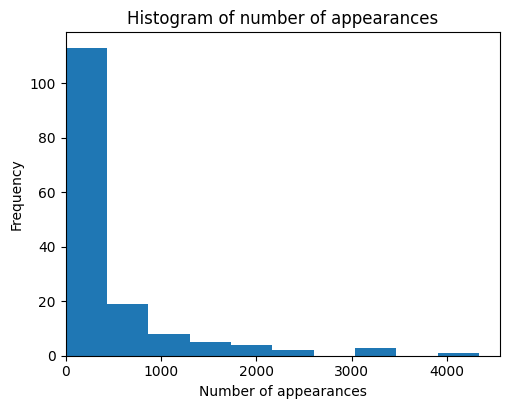

In [16]:
avengers['Appearances'].plot.hist(bins=10);
plt.xlim(0);
plt.xlabel('Number of appearances');
plt.title('Histogram of number of appearances');

The histogram above shows the distribution of values of this variable by splitting the instances into 10 bins, for the purpose of the plot. The [`KBinsDiscretizer` transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) will do the same thing, but instead of plotting the bins, it creates a new variable.

In the following, we will create a new feature called `Appearances_bins` containing 10 bins, from 0 to 9, with equally sized bin intervals. Notice that we need to feed the data to the transformer as a dataframe, therefore the two sets of brackets. We choose the `ordinal` encoding to encode the bins as integers and the `uniform` strategy for equal bin width.

In [17]:
# initialize the transformer with the desired options
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# fit transformer to data
binner.fit(avengers[['Appearances']])

# create a new feature by transforming the data
avengers['Appearances_bins'] = binner.transform(avengers[['Appearances']])

The histogram will look the same as above, but the feature values will range from 0 to 9.

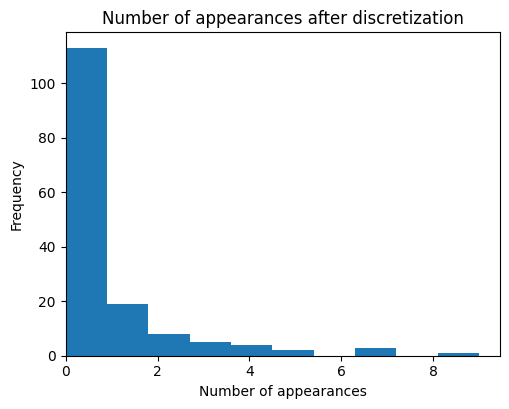

In [18]:
avengers['Appearances_bins'].plot.hist();
plt.xlim(0);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after discretization');

If you want to know the values for the edges of each bin, call:

In [19]:
binner.bin_edges_

array([array([2.0000e+00, 4.3510e+02, 8.6820e+02, 1.3013e+03, 1.7344e+03,
              2.1675e+03, 2.6006e+03, 3.0337e+03, 3.4668e+03, 3.8999e+03,
              4.3330e+03])                                               ],
      dtype=object)

You can play with the options of the transformer to obtain different results. Here we choose the `quantile` strategy so that all bins have the same number of data points.

In [20]:
# initialize the transformer with the desired options
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# fit transformer to data
binner.fit(avengers[['Appearances']])

# create new feature by transforming the data
avengers['Appearances_bins_quartiles'] = binner.transform(avengers[['Appearances']])

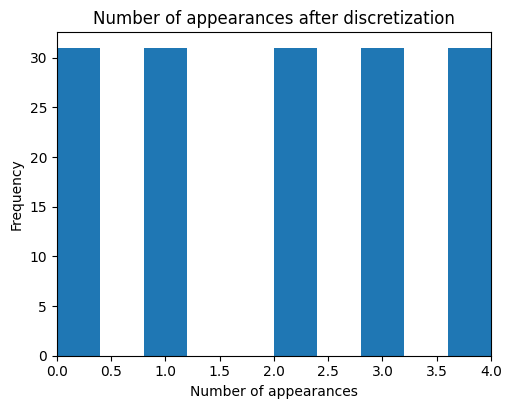

In [21]:
# plot histogram
avengers['Appearances_bins_quartiles'].plot.hist();
plt.xlim(0,4);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after discretization');

#### 2.2.2 Binarization

Binarization is binning with 2 bins. Say you want all the Avengers with up to 1000 appearances to be in bin 0 and all the Avengers with more than 1000 appearances to be in bin 1. For that, you can use the [`Binarizer` transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer) and set the `threshold` to 1000:

In [22]:
# initialize the transformer with the desired options
binarizer = Binarizer(threshold = 1000)

# fit transformer to data
binarizer.fit(avengers[['Appearances']])

# create new feature by transforming the data
avengers['Appearances_binary'] = binarizer.transform(avengers[['Appearances']])

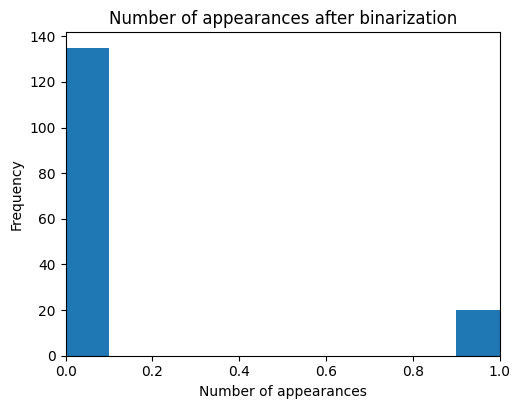

In [23]:
# plot histogram
avengers['Appearances_binary'].plot.hist();
plt.xlim(0,1);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after binarization');

### 2.3 Scaling of numerical data

Often, the numeric variables in the dataset have very different scales, that is, take on different ranges of values.

It's usually a good practice to **scale** them during the preprocessing of our data. These transformations change the data itself, but not the distribution. Why is it important to scale the data?
* When the features have different ranges, some features can dominate the algorithm (e.g. think [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance));
* Different scales can make the models unable to learn correctly from the features with smaller values;
* You don't want your feature to rely on the scale of the measurement because its choice is rather arbitrary;
* Optimization methods (e.g. gradient descent) will converge faster, and otherwise may not converge at all.

A notable exception are *decision tree-based* models that are robust to arbitrary scaling of the data.

Here, we present four examples of scaling transformers.

#### 2.3.1 [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

This transforms all variables so that the minimum and the maximum of the transformed data take certain values $[a,b]$, say, [0, 1]. The general formula to scale $x_i$ from a range $[x_{\min}, x_{\max}] \to [a,b]$ is:

$$ x_i' = \frac{x_i - x_{\min}}{x_{\max} - x_{\min}} \cdot (b-a) + a $$

This scaling preserves zero entries in sparse data. It is also robust to very small standard deviations of features (standard deviation plays a role in the standard scaler explained below).

In [24]:
# initialize the transformer with the desired options
minmaxscaler = MinMaxScaler(feature_range=(0,1))

# fit transformer to data
minmaxscaler.fit(avengers[['Appearances']])

# create new feature by transforming the data
avengers['Appearances_minmax'] = minmaxscaler.transform(avengers[['Appearances']])

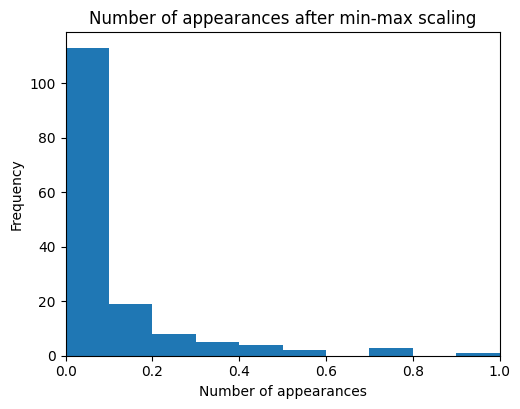

In [25]:
# plot histogram
avengers['Appearances_minmax'].plot.hist();
plt.xlim(0, 1);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after min-max scaling');

#### 2.3.1 [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)

This normalizes each ***row*** of the dataset *individually* to unit norm, independently of the other rows. You can choose between $\ell_2$ (Euclidean distance - default), $\ell_1$ (absolute value of the vector) and $\max$ norms. It is used in models based on distances between features as in clustering or text processing.

The normalizer only makes sense if it is applied to several columns, otherwise you can't compute distances. We're going to use three variables with an initial distribution as below.

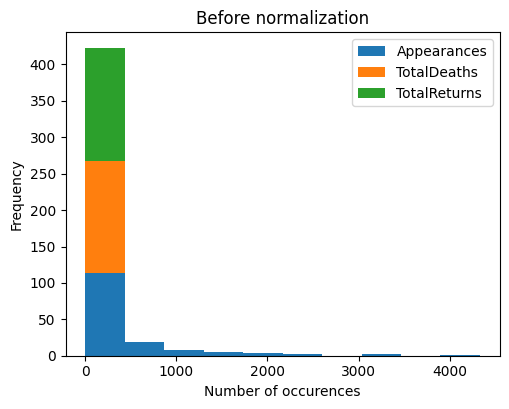

In [26]:
# plot histogram before normalization
# we are using a stacked histogram so that you see all the features
avengers[['Appearances','TotalDeaths','TotalReturns']].plot.hist(stacked=True);
plt.xlabel('Number of occurences');
plt.title('Before normalization');

In [27]:
# initialize the transformer with the desired options
normalizer = Normalizer(norm='l2')

# fit transformer to data
normalizer.fit(avengers[['Appearances', 'TotalDeaths', 'TotalReturns']])

# create new features by transforming the data
X_normalized = normalizer.transform(avengers[['Appearances', 'TotalDeaths', 'TotalReturns']])  # recall that output is a numpy array
avengers['Appearances_normalized'] = X_normalized[:, 0]
avengers['TotalDeaths_normalized'] = X_normalized[:, 1]
avengers['TotalReturns_normalized'] = X_normalized[:, 2]

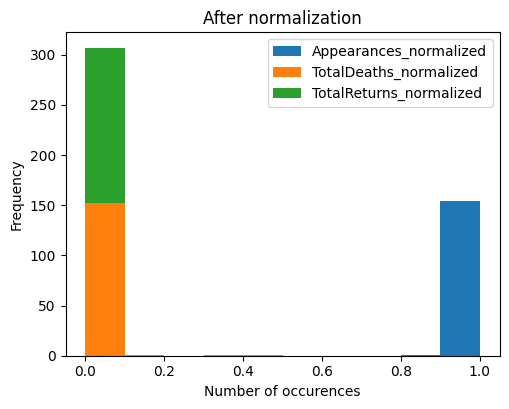

In [28]:
# plot histogram of normalized variables
# we are using a stacked histogram so that you see all the features
avengers[['Appearances_normalized','TotalDeaths_normalized','TotalReturns_normalized']].plot.hist(stacked=True);
plt.xlabel('Number of occurences');
plt.title('After normalization');

#### 2.3.2 [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

Standardization means both centering the data around 0 (by removing the mean) and scaling it to unit variance:

$$ z_i =  \frac{x_i - \mu}{\sigma}$$

Most machine learning models need standardization of features. You have already seen in SLU07 and SLU09 that it is important in gradient descent based models so that they converge properly.

In [29]:
# initialize the transformer with the desired options
standardscaler = StandardScaler()

# fit transformer to data
standardscaler.fit(avengers[['Appearances']])

# create new feature by transforming the data
avengers['Appearances_standard_scaled'] = standardscaler.transform(avengers[['Appearances']])

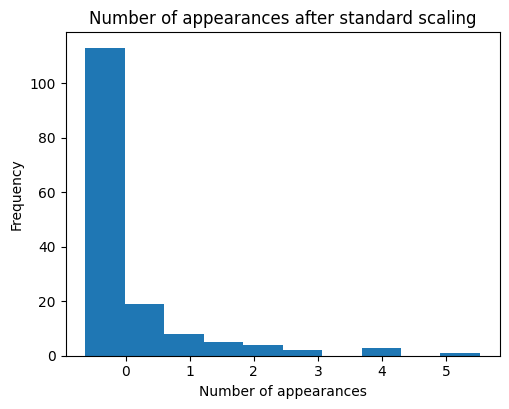

In [30]:
# plot histogram
avengers['Appearances_standard_scaled'].plot.hist();
plt.xlabel('Number of appearances');

plt.title('Number of appearances after standard scaling');

Note that there are also negative values now.

#### 2.3.3 [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)

Scalers differ from each other in the way they estimate the parameters used to shift and scale each feature. In the presence of very large ***outliers***, using the scalers presented above leads to the compression of inliers. Since outliers have an influence on the minimum, maximum, mean and standard deviation, these scalers will shrink the range of the feature values.

The alternative is to scale the features in a way that is robust to outliers. `The RobustScaler` is an alternative to `StandardScaler` using the *median* and the *Interquartile Range* (remember SLU04?) instead of the mean and the standard deviation.

In [31]:
# initialize the transformer with the desired options
robustscaler = RobustScaler()

# fit transformer to data
robustscaler.fit(avengers[['Appearances']])

# create new feature by transforming the data
avengers['Appearances_robust_scaled'] = robustscaler.transform(avengers[['Appearances']])

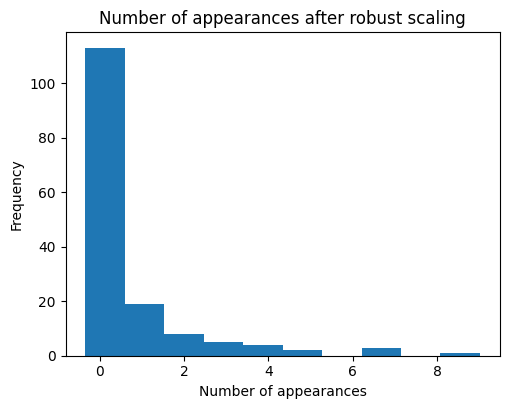

In [32]:
# plot histogram
avengers['Appearances_robust_scaled'].plot.hist();
plt.xlabel('Number of appearances');
plt.title('Number of appearances after robust scaling');

## 3. Dealing with categorical data
A limitation of categorical data is that it usually comes in the form of strings that ML models, in general, don't know how to deal with. We can work around this limitation by encoding categorical variables either as numbers or as dummy variables. Both options have their pros and cons.

The encoding is done with transformers for categorical features. Even though `sklearn` contains such transformers, there is a much better library which you should use instead, [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/). Category encoders take any array-like data, no need to transform it to a dataframe.

In [33]:
import category_encoders as ce

### 3.1 Binary data

A binary variable is a variable with only two possible values, like `Active` and `Gender` in our `avengers` dataset.

Since our models can't deal with data in the form of strings, we need to transform such variables to a numerical form.

The method `Series.map`, mapping inputs to outputs, can be used for simple encodings. Let's use it to convert both columns to 0s and 1s.

In [34]:
avengers = pd.read_csv('data/avengers.csv')

avengers['Active_mapped'] = avengers['Active'].map({'YES': 1, 'NO': 0})
avengers['Gender_mapped'] = avengers['Gender'].map({'MALE': 1, 'FEMALE': 0})
avengers[['Active_mapped','Gender_mapped']].sample(5)

,Active_mapped,Gender_mapped
49,0,1
56,0,1
37,0,0
47,0,1
5,1,1


### 3.2 Ordinal encoding

The [`OrdinalEncoder` transformer](http://contrib.scikit-learn.org/category_encoders/ordinal.html) encodes categorical features as integers. It is similar to the `map` method we used above. It uses a sequence of consecutive integers to represent the classes. The class assignment is random. If our variable has an intrinsic order, we can define a mapping in the form of a dictionary to preserve the order.

For example, the `Universe` field has 7 possible values without an intrinsic order.

In [35]:
avengers.sample(5, random_state=9)

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns,Active_mapped,Gender_mapped
73,Phillip Javert,NO,MALE,Honorary,Earth-921,31,0,0,0,1
51,Ravonna Lexus Renslayer,NO,FEMALE,Full,Earth-6311,41,2,1,0,0
89,Cassie Lang,NO,FEMALE,Full,Earth-616,160,1,1,0,0
122,Anya Corazon,YES,FEMALE,Academy,Earth-616,108,0,0,1,0
26,Stakar,NO,MALE,Honorary,Earth-691,100,0,0,0,1


In [36]:
avengers['Universe'].unique()

array(['Earth-616', 'Earth-691', 'Earth-6311', 'Earth-921', 'Earth-96020',
       'Earth-8009', 'Earth-13034'], dtype=object)

We encode with the `OrdinalEncoder` with default settings.

In [37]:
# initialize the transformer with the desired options
ordinalencoder = ce.ordinal.OrdinalEncoder()

# fit transformer to data
ordinalencoder.fit(avengers['Universe'])

# create new feature by transforming the data
X_encoded = ordinalencoder.transform(avengers['Universe'])
X_encoded.sample(5, random_state=9)

,Universe
73,4
51,3
89,1
122,1
26,2


This is the mapping of the categories to the integer values:

In [38]:
ordinalencoder.category_mapping

[{'col': 'Universe',
  'mapping': Earth-616      1
  Earth-691      2
  Earth-6311     3
  Earth-921      4
  Earth-96020    5
  Earth-8009     6
  Earth-13034    7
  NaN           -2
  dtype: int64,
  'data_type': dtype('O')}]

We fitted the encoder to data with seven categories. What happens if we try to transform data with an **unseen category**, say `Earth-123` or `Earth-999`?

In [39]:
ordinalencoder.transform(pd.DataFrame({'Universe': ['Earth-6311', 'Earth-123', 'Earth-999']}))

,Universe
0,3.0
1,-1.0
2,-1.0


The encoder automatically imputed the value `-1`. This is because, by default, the option `handle_unknown` is set to `value`. The transformers in the `category_encoders` library take care of unseen categories by themselves! You can also choose to set unseen categories to null values or ask the encoder to return an error.

### 3.3 One-hot encoding

Ordinal encoding creates one new feature with integer values for each categorical feature. Even though the values of the integers generally have no meaning, a Machine Learning algorithm might think otherwise and decide that, for example, a category whose encoding is `8` is more important than one with `2`!

To avoid this, we can use one-hot encoding, which, for each categorical feature, creates one new feature for *each category*. This can be implemented with the [`OneHotEncoder` transformer](http://contrib.scikit-learn.org/category_encoders/onehot.html).

In [40]:
# initialize the transformer with the desired options
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator')

# fit transformer to data
ohe.fit(avengers[['Universe']])

# create new feature by transforming the data
X_ohe = ohe.transform(avengers[['Universe']])
X_ohe.sample(5, random_state=9)

,Universe_Earth-616,Universe_Earth-691,Universe_Earth-6311,Universe_Earth-921,Universe_Earth-96020,Universe_Earth-8009,Universe_Earth-13034,Universe_-1
73,0,0,0,1,0,0,0,0
51,0,0,1,0,0,0,0,0
89,1,0,0,0,0,0,0,0
122,1,0,0,0,0,0,0,0
26,0,1,0,0,0,0,0,0


Note how the names of the new features were automatically created (by using the option `use_cat_names`) and how an extra feature (`Universe_-1`) was created for unseen categories (due to the option `handle_unknown='indicator'`).

The `Category Encoders` library contains many more encoders that we will not cover here. Check out the [documentation](http://contrib.scikit-learn.org/category_encoders/index.html) if you like.

## 4. Conclusion

You now know the types of data that you will find in the real world and the options you have to transform it to more convenient forms for the ML models.

Make sure to review this notebook well, and when you're ready, go solve the exercises. Good luck!